# Notebook 2

### Part 2 EDA and cleaning

#### Imports

In [117]:
#cleaning and EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
#wordcloud does not work on python 3.9
#from wordcloud import WordCloud, ImageColorGenerator
#art
from PIL import Image

#misc features for language detection and random selection
import langdetect
import random

In [118]:
#reading in dataset from end of book 1
df = pd.read_csv('../Datasets/combined.csv')

#### Checking for Duplicates and missing values

In [119]:
# based on our checks in the book 1 the dataset is clean and has no nulls, but as a quick check:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  10000 non-null  object
 1   title      10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


No nulls in the dataset as expected

In [120]:
#checking for duplicate entries
dup_titles = [title for title in df[df.title.duplicated()==True]['title']]
dup_titles

["Finnish Man Passes on Paying $22,600 to Replace His Tesla's Battery, Blows Up Car Instead",
 'Police Say School Shooter Had History Of School Shootings',
 'Albatross divorce rates going up due to climate change']

In [121]:
for title in dup_titles:
    print(df[df.title == title][['subreddit', 'title']])

        subreddit                                              title
31       TheOnion  Finnish Man Passes on Paying $22,600 to Replac...
5481  nottheonion  Finnish Man Passes on Paying $22,600 to Replac...
        subreddit                                              title
2058     TheOnion  Police Say School Shooter Had History Of Schoo...
7816  nottheonion  Police Say School Shooter Had History Of Schoo...
        subreddit                                              title
150      TheOnion  Albatross divorce rates going up due to climat...
9001  nottheonion  Albatross divorce rates going up due to climat...


Oddly now that the data for both subreddits have been combined there are 3 titles that appear in both TheOnion and Not the Onion checking online the posts on the Finnish Man and Albatross divorce rates are actual news and was probably posted on The Onion incorrectly and vice versa for the article on the school shooting.

We'll drop them the duplicated titles that are in the wrong subreddit

In [122]:
df.drop(df[(df.title ==dup_titles[0]) & (df.subreddit =='TheOnion') ].index, inplace = True)
df.drop(df[(df.title ==dup_titles[2]) & (df.subreddit =='TheOnion') ].index, inplace = True)

In [123]:
df.drop(df[(df.title ==dup_titles[1]) & (df.subreddit =='nottheonion') ].index, inplace = True)

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9997 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  9997 non-null   object
 1   title      9997 non-null   object
dtypes: object(2)
memory usage: 234.3+ KB


Now that the 3 incorrect posts have been removed, we'll move on to look at out features of the dataset such as post length by subreddit

### Initial EDA

#### Post Length

In [125]:
# Determining the distribution of post titles
#creating a new feature that has the length of the title (characters)
df['title_length'] = df['title'].map(len)

In [126]:
#creating a new feature that has the length of the title (in words)
df['title_word_count'] = df['title'].map(lambda x: len(x.split()))

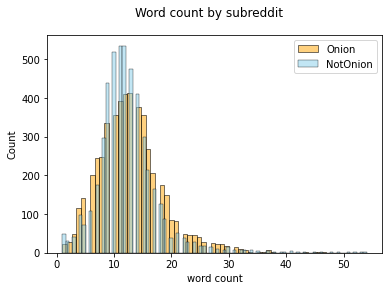

In [127]:
#hist plot of length of post by subreddit
sns.histplot(df[df['subreddit'] == 'TheOnion']['title_word_count'], kde=False, label = 'Onion', color = "orange", alpha = 0.5).set_xlabel('word count')
sns.histplot(df[df['subreddit'] == 'nottheonion']['title_word_count'], kde=False, label = 'NotOnion', color = "skyblue", alpha = 0.5)
plt.legend()

plt.suptitle('Word count by subreddit');

Post length for both subreddits are similar and follow a mostly normal distribution with a noticeably long tails. Posts from both subreddits tend to be be about 10 to 20 words long.

Comparing the post lengths for just 'theonion' and 'nottheonion' we can see that post from the onion tends to have a wider distribution while post from 'nottheonion' are heavily concentrated between 10 to 20 words long with a longer tail.

There are a small number post titles that are just 1-5 words long, which could be errors since news headlines/ satire headlines would need generally need to be of decent length to accurately describe the story. We will review these post to determine if they are errors our outliers.

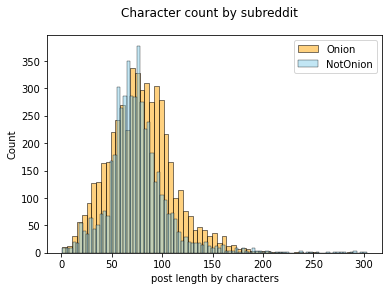

In [128]:
sns.histplot(df[df['subreddit'] == 'TheOnion']['title_length'], kde=False, label = 'Onion', color = "orange", alpha = 0.5).set_xlabel('post length by characters')
sns.histplot(df[df['subreddit'] == 'nottheonion']['title_length'], kde=False, label = 'NotOnion', color = "skyblue", alpha = 0.5)
plt.legend()

plt.suptitle('Character count by subreddit');

We see a similar distribution for post length by characters where both subreddits have a bell shaped distribution with long right tails.

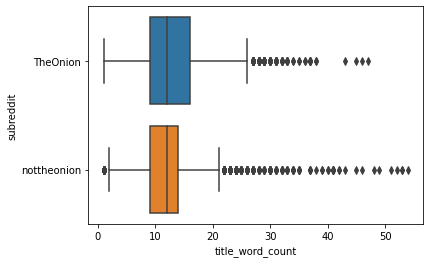

In [129]:
#Box plot of data split by subreddit:
sns.boxplot(data = df, x = df['title_word_count'], y=df['subreddit']);

Box plots paint a similar picture with median title length of both subreddits is around the same at about 10+ but 'nottheonion' has a longer tail with the max post length reaching 50+ words

In [130]:
# reviewing titles with low word counts
df.sort_values(by = 'title_word_count').head(20)

,subreddit,title,title_length,title_word_count
6396,nottheonion,da,2,1
5766,nottheonion,2021.12.23早，老白，開播！,18,1
5368,nottheonion,2021.12.28早，老白，開播！,18,1
7014,nottheonion,2021.12.14早，小圓子，開播！,19,1
6634,nottheonion,2021.12.17早，老白，開播！,18,1
2785,TheOnion,https://politics.theonion.com/one-eyed-man-who...,96,1
7821,nottheonion,WHAT,4,1
1008,TheOnion,Pro-life-texas-lawmaker-introduces-bill-imposi...,75,1
6050,nottheonion,2021.12.21早，老白，開播！,18,1
7214,nottheonion,磨砂珠子很有特色，珠子大小作为配链或者手链都很合适，很好搭配件，性价比高。,37,1


Sorting by word count we can see that for post that only consist of one word, it is hard to discern any meaning from the posts the titles appear to be mostly just hyperlinks, posts written in non-english, titles that don't provide enough context (eg. 'jjjjj', 'superglue....') or just emojis, we'll remove these posts.

In [131]:
df.sort_values(by = 'title_word_count').tail(20)

,subreddit,title,title_length,title_word_count
5031,nottheonion,Marjorie Taylor Greene Says She Wants To Take ...,238,41
5378,nottheonion,@RandPaul: How to steal an election: “Seeding ...,264,41
8561,nottheonion,Tom Cruise has been practicing a new stunt for...,225,41
6675,nottheonion,While attractive hospitality workers typically...,297,41
9233,nottheonion,Emphatic stress is stress imposed on a word in...,237,42
9394,nottheonion,WAEC/WASSCE ORAL ENGLISH QUESTIONS AND ANSWERS...,291,42
4606,TheOnion,Heartbreaking: This Kid Is Too Young To Realiz...,215,43
6796,nottheonion,"In most English exams, students are asked to f...",287,43
113,TheOnion,The Sydney Opera House in Australia has renewe...,253,45
5462,nottheonion,"Finnish Man Passes on Paying $22,600 to Replac...",243,45


On the other hand the post with high word counts are acceptable as they seem to provide insight to the contents of the article.

In [132]:
#dropping post with title_word_count of 1.
df.drop(df[df.title_word_count<2].index, inplace = True)

In [133]:
# reviewing post with word_count of 2
df[df.title_word_count ==2]

,subreddit,title,title_length,title_word_count
229,TheOnion,The onion,9,2
360,TheOnion,nothing happened,16,2
591,TheOnion,onion ice,9,2
698,TheOnion,Badum tsssssss!!!!!!!,21,2
895,TheOnion,Derek chauvinist,16,2
946,TheOnion,Pennington indiana,18,2
1088,TheOnion,Seems sensible,14,2
1226,TheOnion,5000% Up,8,2
1295,TheOnion,Finders keepers,15,2
1445,TheOnion,Excellent journalism!,21,2


There are still some characters that are not in english (eg. index 9621, 9656) and emojis. We'll use langdetector to check if there are any titles that are not in english and drop them.

In [134]:
#using langdetect to state the language of the post in a seperate column
df['language'] = [langdetect.detect(title) for title in df['title']]

In [135]:
#dropping rows that are not in english
rows_to_drop = []
for index, row in df.iterrows():
    if row['language'] != 'en':
        rows_to_drop.append(row.name)

In [136]:
for i in rows_to_drop:
    df.drop( i, inplace = True)

In [137]:
df[df.title_word_count ==2]

,subreddit,title,title_length,title_word_count,language
229,TheOnion,The onion,9,2,en
360,TheOnion,nothing happened,16,2,en
591,TheOnion,onion ice,9,2,en
946,TheOnion,Pennington indiana,18,2,en
1600,TheOnion,SeaWorld Bad,12,2,en
1796,TheOnion,Tortube movies,14,2,en
1929,TheOnion,Spring Cleaning,15,2,en
1943,TheOnion,An onion.,9,2,en
2137,TheOnion,Earth Explodes,14,2,en
2184,TheOnion,Nerd Immunity,13,2,en


Emojis are still in the dataset but we'll keep them since they will be ignored by count vectorizer.

In [138]:
# converting subreddit to 0 for not the onion and 1 for the onion:
df['labels'] = df['subreddit'].map({'TheOnion': 1, 'nottheonion': 0})

In [139]:
df.corr()

,title_length,title_word_count,labels
title_length,1.000000,0.950720,0.061763
title_word_count,0.950720,1.000000,0.050675
labels,0.061763,0.050675,1.000000


title_length (in characters) and tile_count seems to have a low correlation with subreddit as such we will not include them as possible features during the modelling process.

In [140]:
#instantiating count vectorizer to explore word counts/types
cv = CountVectorizer()

In [141]:
#fitting and transforming count vectorizer on our df
vec_df = cv.fit_transform(df['title'])

In [142]:
#creating a dataframe with the words used in the data and the number of times the words are used
word_df = pd.DataFrame(vec_df.todense(), columns = cv.get_feature_names_out())

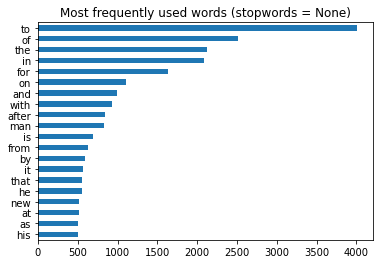

In [143]:
# finding out the top words used in the entire dataset
bar = word_df.sum().sort_values(ascending=True).tail(20).plot(kind='barh')
bar.set_title('Most frequently used words (stopwords = None)');

20 most common words seem to be mostly preposition, conjunctions, adverbs and pronouns ('stopwords'). These words tend to provide low-level information and removing them can help improve performance as the model can place more focus on words that are more meaningful.

Instead of outright removing them we can add stopwords as a parameter during the vectorizing stage to determine if the model does better with/without stopwords.

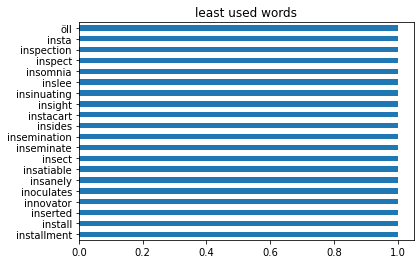

In [144]:
bar = word_df.sum().sort_values(ascending=False).tail(20).plot(kind='barh')
bar.set_title("least used words");

In the bottom 20 words we see similar words like inseminate and insemination that have the same root word (e.g. inseminate), this indicates that lemmatization might be required to reduce the number of features prior to vectorization. Lemmatizing would likely reduce modelling time and improve model performance while maintaining the meaning of post titles.

In [145]:
#instantiating count vectorizer to explore word counts without stopwords and with max_df as well
cv_bi = CountVectorizer( min_df=3, max_df = 0.3, stop_words = 'english', ngram_range = (1,2))

In [146]:
#fitting and transforming with our new cv params
vec_df_nostop_bi = cv_bi.fit_transform(df['title'])

In [147]:
# storing outputs into a dataframe
vec_df_nostop_bi = pd.DataFrame(vec_df_nostop_bi.todense(), columns = cv_bi.get_feature_names_out())

In [148]:
top_words_bi = vec_df_nostop_bi.sum().sort_values(ascending = False).head(15)

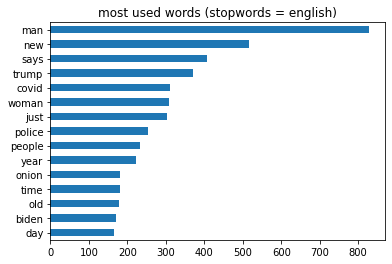

In [149]:
#plotting most used terms
bar = top_words_bi.sort_values().plot(kind='barh')
bar.set_title("most used words (stopwords = english)");

Removing stopwords the word "Onion" appears about 200 times which is likely a direct reference to the 'theonion'. We should remove such entries from the dataset as well so that the model is sufficiently generalised to find fake news that is not from theonion.

In [150]:
#dropping posts that contain the word "onion'
for title in df.title:
    if 'Onion' in title or 'onion' in title:
        df.drop(df[df.title==title].index, inplace = True)

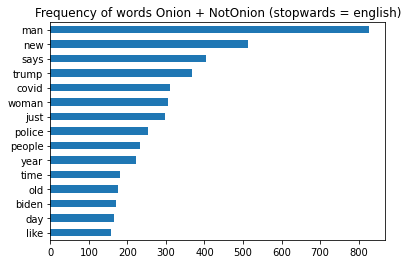

In [151]:
#re-vectorizing
vec_df_nostop_bi = cv_bi.fit_transform(df['title'])
word_df_nostop_bi = pd.DataFrame(vec_df_nostop_bi.todense(), columns = cv_bi.get_feature_names_out())
top_words_bi = word_df_nostop_bi.sum().sort_values(ascending=False).head(15)

bar = top_words_bi.sort_values().plot(kind='barh')
bar.set_title('Frequency of words Onion + NotOnion (stopwards = english)');

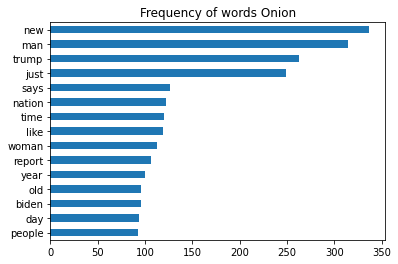

In [152]:
#frequency of words for onion
df_title_onion = df[df['labels']==1][['title']]
vec_df_onion = cv_bi.fit_transform(df_title_onion['title'])
word_df_onion = pd.DataFrame(vec_df_onion.todense(), columns = cv_bi.get_feature_names_out())
top_words_bi = word_df_onion.sum().sort_values(ascending=False).head(15)

bar = top_words_bi.sort_values().plot(kind='barh')
bar.set_title('Frequency of words Onion');

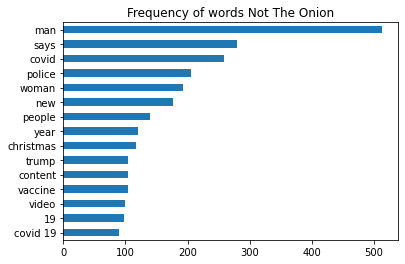

In [153]:
df_title_notonion = df[df['labels']==0][['title']]
vec_df_notonion = cv_bi.fit_transform(df_title_notonion['title'])
word_df_notonion = pd.DataFrame(vec_df_notonion.todense(), columns = cv_bi.get_feature_names_out())
top_words_bi = word_df_notonion.sum().sort_values(ascending=False).head(15)

bar = top_words_bi.sort_values().plot(kind='barh')
bar.set_title('Frequency of words Not The Onion');

After removing stop words and 'Onion' the most common words are Trump, Covid, Trump and Biden indication that posts might be generally related to political/health matters.

Separating the data based on subreddit there isn't much overlap between the two subreddits with the exception of general terms (e.g. man, woman etc)

For the final part of the cleaning process we will quickly review the remaining rows to ensure that there is sufficient data from both subreddits

In [164]:
#Checking if number of samples for both onion and not onion is the same
df.groupby('subreddit').count()


,title,title_length,title_word_count,language,labels
subreddit,,,,,
TheOnion,4650,4650,4650,4650,4650
nottheonion,4775,4775,4775,4775,4775


In [165]:
#there are more entries of nontheonion than the onion, we'll balance them out by dropping rows at random from not the onion till both datasets are even.
#first we'll sort and reset index
df.sort_values(by = 'subreddit', inplace = True, ascending = False)
df.reset_index(inplace = True, drop = True)


In [166]:
#seperate the dataset 2 smaller sets split by subreddit
df_not = df[df.subreddit == "nottheonion"][['subreddit', 'title', 'title_length', 'title_word_count', 'language']]
df_onion = df[df.subreddit == "TheOnion"][['subreddit', 'title', 'title_length', 'title_word_count', 'language']]

The number of samples from each subreddit is now uneven. For classification problems a balanced dataset would be ideal since no one class takes precedence over the other. This results in more balanced and fair metrics.

In [167]:
# creating a loop that will iterate through the df_not dataframe and cut rows at random until the number of observations for theonion and nottheonion is the same.
for i in range(0, (len(df_not)-len(df_onion))):
    number = random.randint(0, len(df_not))
    df_not.drop(number, inplace = True)
    df_not.reset_index(inplace = True, drop = True)

In [168]:
df_onion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4650 entries, 4775 to 9424
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   subreddit         4650 non-null   object
 1   title             4650 non-null   object
 2   title_length      4650 non-null   int64 
 3   title_word_count  4650 non-null   int64 
 4   language          4650 non-null   object
dtypes: int64(2), object(3)
memory usage: 218.0+ KB


In [169]:
df_not.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4650 entries, 0 to 4649
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   subreddit         4650 non-null   object
 1   title             4650 non-null   object
 2   title_length      4650 non-null   int64 
 3   title_word_count  4650 non-null   int64 
 4   language          4650 non-null   object
dtypes: int64(2), object(3)
memory usage: 181.8+ KB


In [170]:
# observations from each subreddit is now the same, we'll recombine the datasets and save it under a cleaned CSV
df_combined = df_onion.append(df_not)

In [171]:
df_combined.to_csv('../Datasets/combined_cleaned.csv', index = False)

In [172]:
# end of book 2